## Problem Set 1: Gaussians and Visualization
### Made by Denis Fatykhoph

### Task 1: Probability
**A.** Plot the probability density function $ p(x) $ of a one dimensional Gaussian distribution $ \mathcal{N} (x; 1, 1) $ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

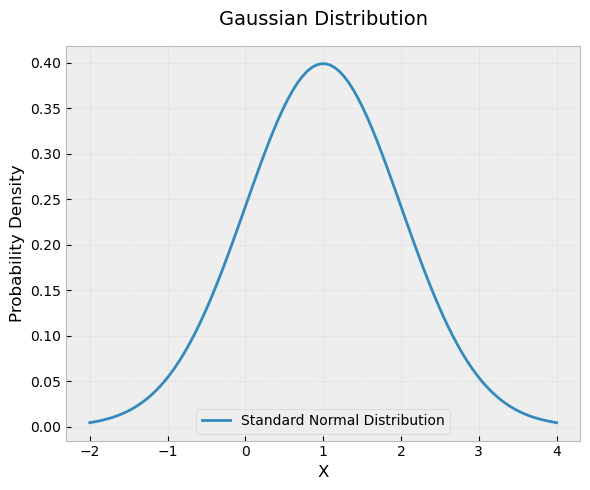

In [2]:
plt.style.use('bmh')  # or 'ggplot', 'bmh', 'classic'

x = np.linspace(-2, 4, 100)
dist_pdf = stats.norm.pdf(x , 1, 1)

plt.figure(figsize=(6, 5))
plt.plot(x, dist_pdf, linewidth=2, label='Standard Normal Distribution')

plt.title('Gaussian Distribution', fontsize=14, pad=15)
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

**B.** Calculate the probability mass that the random variable $ X $ is less than $ 0 $, that is, $Pr \left\{ X \le 0 \right\} = \int_{-\infty}^{0} p(x) dx$

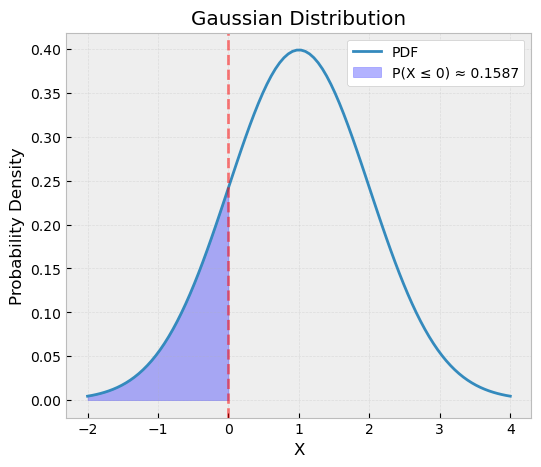

In [3]:
probability = stats.norm.cdf(0, loc=1, scale=1)

plt.figure(figsize=(6, 5))
plt.plot(x, dist_pdf, label='PDF')

# Shade the area for X ≤ 0
mask = x <= 0
plt.fill_between(x[mask], dist_pdf[mask], color='blue', alpha=0.3, 
                 label=f'P(X ≤ 0) ≈ {probability:.4f}')

# Vertical line at x=0
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)

plt.title('Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True, alpha=0.3)
plt.legend(facecolor='white', framealpha=1)
plt.show()

**C.** Consider the new observation variable $ z $, it gives information about the variable $ x $ by the likelihood function $ p(z|x) = \mathcal{N} \left( z; x, \sigma^2 \right) $, with variance $ \sigma^2 = 0.2 $. Apply the Bayes’ theorem to derive the posterior distribution, $ p(x|z) $, given an observation $ z = 0.75 $ and plot it. For a better comparison, plot the prior distribution, $ p(x) $, too.

According to Baies' theorem:

$$
p(x|z) = \frac{p(z|x)p(x)}{p(z)}
$$

We know $p(x)$ from the previous task and we can obtain $p(z|x)$ from the normal distribution with parameters as in task. But we need to find $p(z)$. There is several options how to obtain it:

1. We can integrate $p(z|x)$ over all $x$ (so called marginalization):

$$
p(z) = \int_{-\infty}^{\infty} p(z|x)p(x)dx
$$

2. We can calculate mean and variance parameters of the normal distribution for $p(z)$:

$$
\mu_z = \sigma_z \times \left( \frac{\mu_x}{\sigma_x} + \frac{z}{\sigma_z} \right)
$$

$$
\sigma_z = \frac{1}{\frac{1}{\sigma_x} + \frac{1}{\sigma_z}}
$$

Thus, we will obtain distribution $p(x|z) \sim \mathcal{N}(z, \mu_z, \sigma_z)$ 

Let's try both options and compare results.

In [4]:
z = 0.75
sigma_z = 0.2
prior_mean = 1
prior_var = 1

def integrand(x):
    likelihood = stats.norm.pdf(z, x, np.sqrt(sigma_z))  # p(z|x)
    prior = stats.norm.pdf(x, prior_mean, np.sqrt(prior_var))  # p(x)
    return likelihood * prior

# Rectangle method
dx = x[1] - x[0]  # Width of each rectangle
p_z = np.sum(integrand(x) * dx)  # Area = sum of (height * width)

print(f"p(z) = {p_z:.4f}")


p(z) = 0.3548


In [5]:
posterior_hand_made = (stats.norm.pdf(x, prior_mean, np.sqrt(prior_var))
                       * stats.norm.pdf(z, x, np.sqrt(sigma_z)))/(p_z)

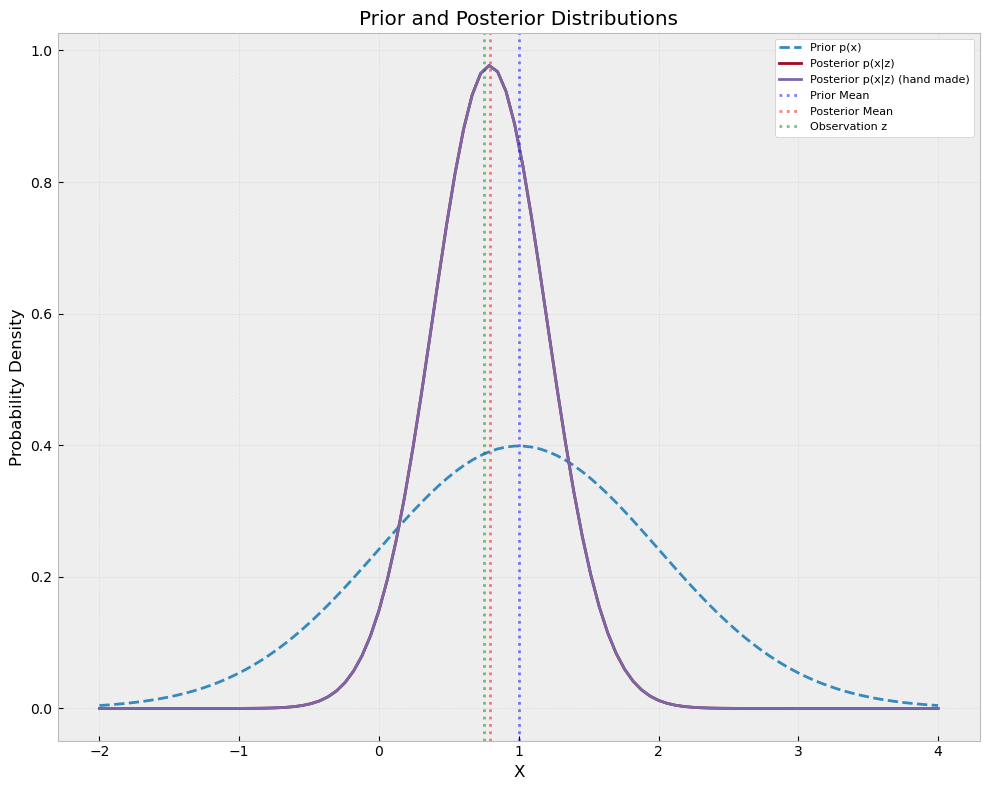

In [6]:
# Parameters
z = 0.75
sigma_z = 0.2
prior_mean = 1
prior_var = 1

# Bayes theorem
posterior_var = 1 / (1/prior_var + 1/sigma_z)
posterior_mean = posterior_var * (prior_mean/prior_var + z/sigma_z)

# Calculate PDFs
prior_pdf = stats.norm.pdf(x, prior_mean, np.sqrt(prior_var))
posterior_pdf = stats.norm.pdf(x, posterior_mean, np.sqrt(posterior_var))

plt.figure(figsize=(10, 8))
plt.plot(x, prior_pdf, label='Prior p(x)', linestyle='--')
plt.plot(x, posterior_pdf, label='Posterior p(x|z)')
plt.plot(x, posterior_hand_made, label='Posterior p(x|z) (hand made)')

plt.axvline(x=prior_mean, color='blue', linestyle=':', alpha=0.5, label='Prior Mean')
plt.axvline(x=posterior_mean, color='red', linestyle=':', alpha=0.5, label='Posterior Mean')
plt.axvline(x=z, color='green', linestyle=':', alpha=0.5, label='Observation z')

plt.title('Prior and Posterior Distributions')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True, alpha=0.3)
plt.legend(facecolor='white', framealpha=1, fontsize=8)
plt.tight_layout()
plt.show()


### Task 2. Multivariate Gaussian 
**A.** Write the function `plot2dcov` which plots the 2d contour given three core parameters: mean, covariance, and the iso-contour value k. You may add any other parameter such as color, number of points, etc.

Then, use `plot2dcov` to draw the iso-contours corresponding to $ 1,2,3- \sigma $ of the following Gaussian distributions: $\mathcal{N} \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 1 & 0 \\ 0 & 2 \end{bmatrix} \right) $, $\mathcal{N} \left( \begin{bmatrix} 5 \\ 0 \end{bmatrix}, \begin{bmatrix} 3 & -0.4 \\ -0.4 & 2 \end{bmatrix} \right)$ and $\mathcal{N} \left( \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \begin{bmatrix} 9.1 & 6 \\ 6 & 4 \end{bmatrix} \right)$. Use `the set_aspect(’equal’)` command and comment on them.

In [7]:
def plot2dcov(mean, cov, k, n_points=100, color='blue', alpha=0.5, label=None):
    """
    Plot 2D Gaussian contours
    
    Parameters:
    mean: 2D mean vector
    cov: 2x2 covariance matrix 
    k: sigma multiplier for iso-contour
    color: contour color
    n_points: number of points for contour
    alpha: transparency
    label: legend label
    """
    theta = np.linspace(0, 2*np.pi, n_points)
    circle = np.vstack([np.cos(theta), np.sin(theta)])
    
    A = np.linalg.cholesky(cov)
    
    scaled = k * circle
    transformed = A @ scaled + mean[:, np.newaxis]
    
    return plt.plot(transformed[0,:], transformed[1,:], color=color, alpha=alpha, label=label)


In [8]:
mean = np.array([
    [0, 5, 2],
    [0, 0, 2]
])

cov = np.array([
    [1, 0, 3, -0.4, 9.1, 6],
    [0, 2, -0.4, 2, 6, 4]
])

for i in range(len(mean.T)):
    print(f'mean\n {mean[:,i]}')
    print(f'cov\n {cov[:,2*i:2*(i+1)]}')

mean
 [0 0]
cov
 [[1. 0.]
 [0. 2.]]
mean
 [5 0]
cov
 [[ 3.  -0.4]
 [-0.4  2. ]]
mean
 [2 2]
cov
 [[9.1 6. ]
 [6.  4. ]]


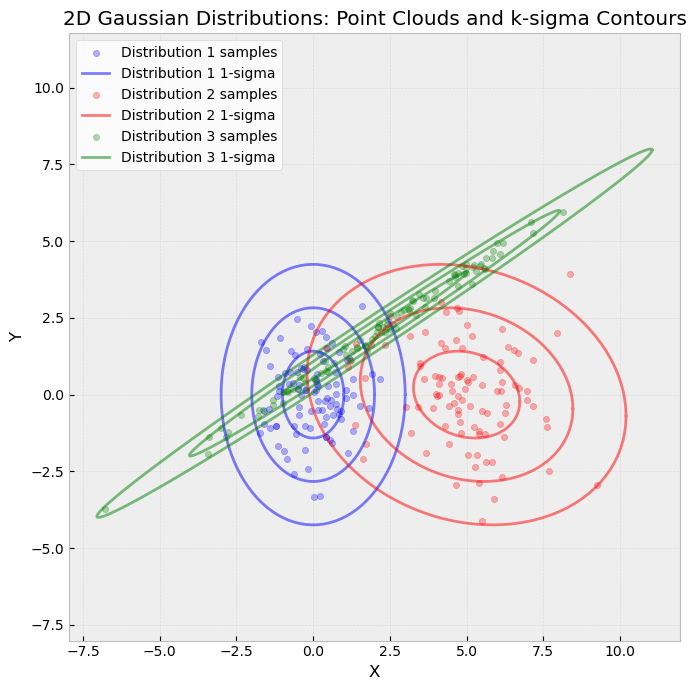

In [9]:
# Create figure
plt.figure(figsize=(7,7))

# Plot contours for each distribution
sigmas = [1, 2, 3]
distributions = [
    (mean[:,0], cov[:,0:2], 'Distribution 1'),
    (mean[:,1], cov[:,2:4], 'Distribution 2'),
    (mean[:,2], cov[:,4:6], 'Distribution 3')
]
colors = ['blue', 'red', 'green']

# Generate and plot point clouds
n_samples = 100
for (mu, sigma, name), color in zip(distributions, colors):
    # Generate random samples
    original_cloud = np.random.randn(n_samples, 2)
    A = np.linalg.cholesky(sigma)
    cloud = (A @ original_cloud.T + mu.reshape(-1,1)).T
    
    # Plot point cloud
    plt.scatter(cloud[:,0], cloud[:,1], c=color, alpha=0.3, s=20, label=f'{name} samples')
    
    # Plot contours
    for k in sigmas:
        plot2dcov(mu, sigma, k, color=color, alpha=0.5,
                 label=f'{name} {k}-sigma' if k==1 else None)

plt.grid(True, alpha=0.3)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Gaussian Distributions: Point Clouds and k-sigma Contours')
plt.legend(facecolor='white', loc='upper left')
plt.axis('equal')  # set_aspect('equal')
plt.tight_layout()
plt.show()


**B.**  Write the equation of sample mean and sample covariance of a set of points $ \left\{ x_i \right\} $, in vector form as was shown during the lecture. You can provide your solution by using Markdown, latex, by hand, etc.

From first lecture, the sample mean is expectation of the set:

$$
\bar{x} = \frac{1}{N} \sum_{i=1}^{N} x_i
$$

The sample covariance matrix is defined as:

$$
\bar{\Sigma} = \frac{1}{N - 1} \sum_{i=1}^{N} (x_i - \bar{x})(x_i - \bar{x})^T
$$

**C.** Draw random samples from a multivariate normal distribution. You can use the python function that draws samples from the univariate normal distribution $ \mathcal{N}(0,1) $. In particular, draw and plot 200 samples from $ \mathcal{N} \left( \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \begin{bmatrix} 1 & 1.3 \\ 1.3 & 3 \end{bmatrix} \right) $; also plot their corresponding 1-sigma iso-contour. Then calculate the sample mean and covariance in vector form and plot again the 1-sigma iso-contour for the estimated Gaussian parameters. Run the experiment multiple times and try a different number of samples (e.g. 50, 400). Comment briefly on the results

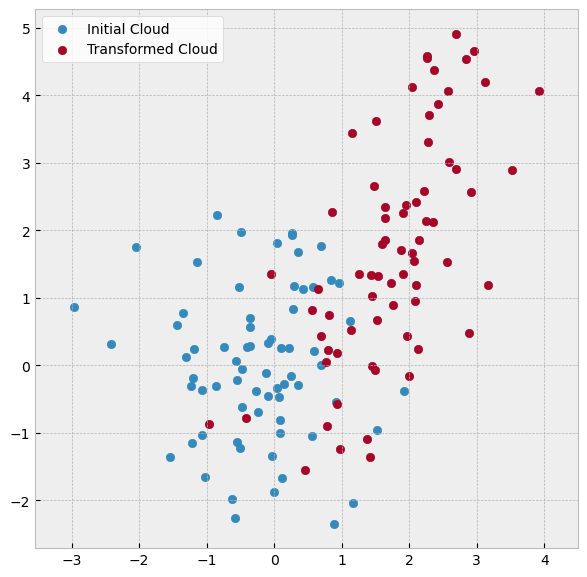

In [10]:
n_samples = 70
original_cloud = np.random.randn(n_samples, 2)

mean = np.array([
    [2],
    [2]
])

cov = np.array([
    [1, 1.3],
    [1.3, 3]
])

A = np.linalg.cholesky(cov)
cloud = (A @ original_cloud.T + mean).T

plt.figure(figsize=(7,7))
plt.scatter(original_cloud[:,0], original_cloud[:,1],label='Initial Cloud')
plt.scatter(cloud[:,0], cloud[:,1],label='Transformed Cloud')
plt.axis('equal')
plt.legend(facecolor='white')
plt.show()

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_74199/1704225953.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(ellipse[0,:], ellipse[1,:], 'r-', color='blue', label='1-k Contour')


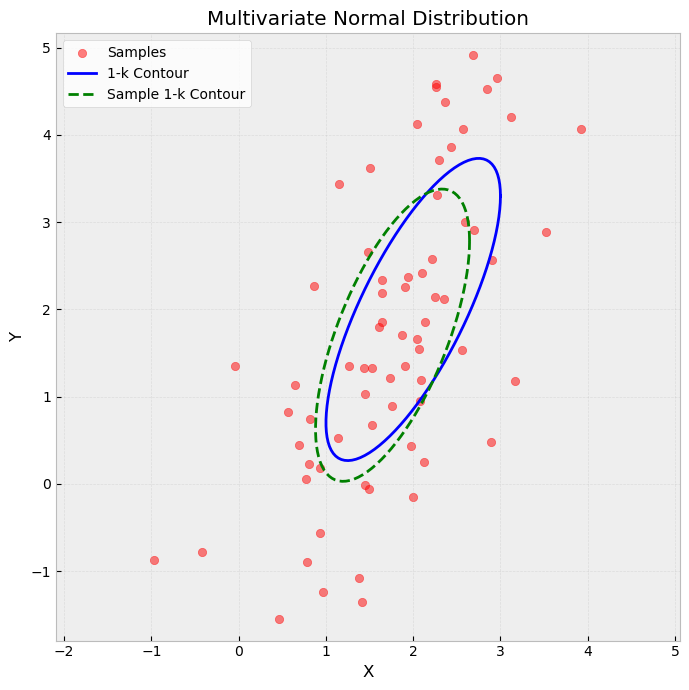

In [11]:
plt.figure(figsize=(7,7))
plt.scatter(cloud[:,0], cloud[:,1], alpha=0.5, color='red', label='Samples')

theta = np.linspace(0, 2*np.pi, 100)
circle = np.vstack([np.cos(theta), np.sin(theta)])

A = np.linalg.cholesky(cov)
ellipse = A @ circle + mean
plt.plot(ellipse[0,:], ellipse[1,:], 'r-', color='blue', label='1-k Contour')

sample_mean = np.mean(cloud, axis=0).reshape(-1,1)
sample_cov = np.cov(cloud.T)
A_sample = np.linalg.cholesky(sample_cov)

sample_ellipse = A_sample @ circle + sample_mean
plt.plot(sample_ellipse[0,:], sample_ellipse[1,:], 'g--', label='Sample 1-k Contour')

plt.grid(True, alpha=0.3)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Multivariate Normal Distribution')
plt.legend(facecolor='white', loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.show()

Observations on Sample Size Effects:
- With a larger number of samples (70+), the sample covariance ellipse (green) closely matches the true covariance ellipse (blue)
- With fewer samples (e.g., <50), there is more discrepancy between sample and true covariance due to increased sampling variability
- The sample mean (center of green ellipse) also becomes more accurate with increased sample size

### Task 3. Covariance Propagation
Discrete-time propagation model:

$$
\begin{bmatrix} x \\ y \end{bmatrix}_t = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix}_{t-1} + \begin{bmatrix} \Delta t & 0 \\ 0 & \Delta t \end{bmatrix} \begin{bmatrix} v_x \\ v_y \end{bmatrix}_t + \begin{bmatrix} \eta_x \\ \eta_y \end{bmatrix}_t	
$$

Control: 

$$
u = \left[v_x, v_y\right]^T
$$

Uncertainty on command execution:

$$
\begin{bmatrix} \eta_x \\ \eta_y \end{bmatrix}_t \sim \mathcal{N} \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right)
$$

Time step is $\Delta t = 0.5$

**A.** Write the equations corresponding to the mean and covariance after a single propagation of the holonomic platform.

We can rewrite Discrete-time propagation model as:

$$
\begin{cases}
x_t = x_{t-1} + \Delta t v_{xt} + \eta_{xt} \\
y_t = y_{t-1} + \Delta t v_{yt} + \eta_{yt}
\end{cases}
$$

Then propagate mean:

$$
\mu_x = E\{x_t\} = E\{x_{t-1} + \Delta t v_{xt} + \eta_{xt}\} \\
\mu_x = E\{x_{t-1}\} + E\{\Delta t v_{xt}\} + E\{\eta_{xt}\} \\
\mu_x = \mu_{x-1} + \Delta t v_{xt} + 0
$$

Similar equation we can write for $y_t$:

$$
\mu_y = \mu_{y-1} + \Delta t v_{yt} + 0
$$

And write this in matrix form:

$$
\mu_t = \begin{bmatrix} \mu_x \\ \mu_y \end{bmatrix}_t = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \mu_{t-1} + \begin{bmatrix} \Delta t & 0 \\ 0 & \Delta t \end{bmatrix} u_t, where \ \mu_{t-1} = \left[\mu_x, \mu_y\right]^T_{t-1} \ and \ u_t = \left[v_{xt}, v_{yt}\right]^T 
$$


And for covariance:

$$
\Sigma_x = E\{(x_t - \mu_x)(x_t - \mu_x)^T\} =
$$

$$
= E\{(x_{t-1} + \bcancel{\Delta t v_{xt}} + \eta_{xt} - \mu_{x-1} - \bcancel{\Delta t v_{xt}})(x_{t-1} + \eta_{xt} - \mu_{x-1})^T\} =
$$

$$
= E\{\underbrace{(x_{t-1} - \mu_{x-1})(x_{t-1} - \mu_{x-1})^T}_{cov(x_{t-1}) \ \text{by def.}} + (x_{t-1} - \mu_{x-1})\eta_{xt}^T + \underbrace{\eta_{xt}\eta_{xt}^T}_{var(\eta_x) \ \text{by def.}}\}
$$

$$
= \Sigma_{x_{t-1}} + E\{x_{t-1}\} \cancel{E\{\eta_{xt}^T\}} - \mu_{x-1} \ \cancel{\mu_{xt}^T} + \Sigma_{\eta_x}
$$

Finally:
$$
\Sigma_x = \Sigma_{x_{t-1}} + \Sigma_{\eta_x}
$$

And similar for $y_t$:

$$
\Sigma_y = \Sigma_{y_{t-1}} + \Sigma_{\eta_x}
$$

In matrix form:

$$
\Sigma_t = \begin{bmatrix} \Sigma_x \\ \Sigma_y \end{bmatrix}_t = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \Sigma_{t-1} + \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \Sigma_{\eta}
$$



Thus we obtain:

$$
x_t \sim \mathcal{N}(\mu_t, \Sigma_t)
$$

**B.** Show how to use this result iteratively for multiple propagations.

For iterative propagation over multiple steps, we have the basic update equations:

$$
\mu_t = \begin{bmatrix} \mu_x \\ \mu_y \end{bmatrix}_t = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \mu_{t-1} + \begin{bmatrix} \Delta t & 0 \\ 0 & \Delta t \end{bmatrix} u_t \ \text{ and }
$$

$$
\Sigma_t = \begin{bmatrix} \Sigma_x \\ \Sigma_y \end{bmatrix}_t = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \Sigma_{t-1} + \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \Sigma_{\eta}
$$

For n-step propagation, the position evolves as:

$$
\begin{bmatrix} x \\ y \end{bmatrix}_n = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix}_{0} + \begin{bmatrix} \Delta t & 0 \\ 0 & \Delta t \end{bmatrix} \sum_{i=0}^{n} \begin{bmatrix} v_x \\ v_y \end{bmatrix}_i + \sum_{i=0}^{n} \begin{bmatrix} \eta_x \\ \eta_y \end{bmatrix}_i	
$$

The mean after **n** steps becomes with constant control command $u$:

$$
\mu_n = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \mu_{0} + n \begin{bmatrix} \Delta t & 0 \\ 0 & \Delta t \end{bmatrix} u_0 
$$

The covariance accumulates linearly:

$$
\Sigma_t = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \Sigma_{0} + n \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \Sigma_{\eta}
$$

Therefore, the final n-step distribution is:

$$
x_n \sim \mathcal{N}(\mu_0 + n\Delta t u, \Sigma_0 + n\Sigma_\eta)
$$

**C.** Draw the propagation state PDF ($1-\sigma$ iso-contour) for times indexes $t = 0, \dots ,5$ and the control sequence $u = \left[3, 0 \right]^T$ for all times $t$. The PDF for the initial state is $\mathcal{N} \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right)$.

(-1.4281423850718846, 9.702378233965371, -2.757564451593931, 2.341541226535586)

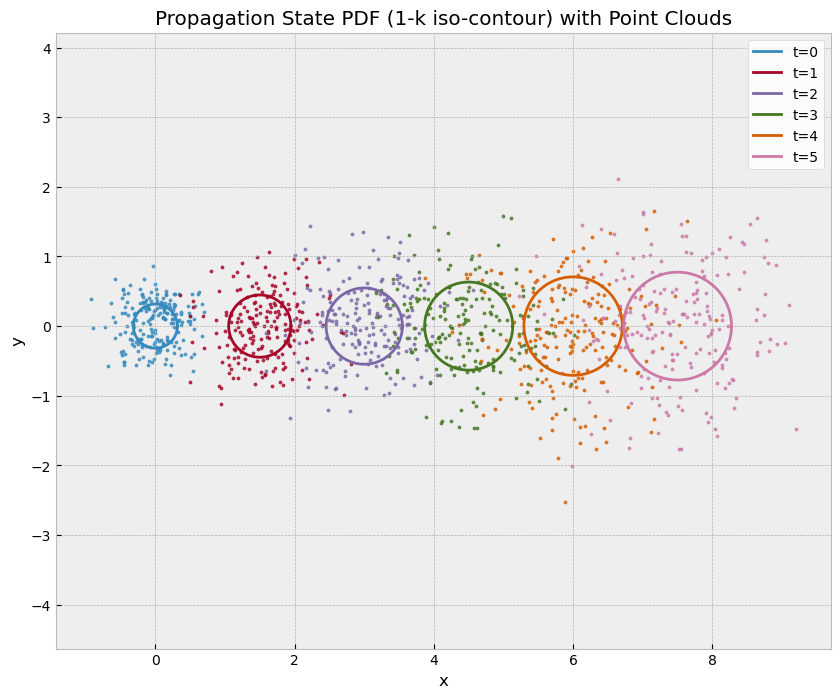

In [13]:
mu_initial = np.array([0, 0])
u_control = np.array([3, 0])
cov_initial = np.array([[0.1, 0], [0, 0.1]])
sigma_eta = np.array([[0.1, 0], [0, 0.1]])
dt = 0.5

plt.figure(figsize=(10, 8))

# For each time step
for n in range(6):
    # Calculate mean at time t
    mu_t = mu_initial + n * dt * u_control
    
    # Calculate covariance at time t
    sigma_t = cov_initial + n * sigma_eta
    
    L = np.linalg.cholesky(sigma_t)
    
    # Generate points for 1-sigma ellipse
    theta = np.linspace(0, 2*np.pi, 100)
    ellipse = np.zeros((2, theta.size))
    
    for i in range(theta.size):
        circle_pt = np.array([np.cos(theta[i]), np.sin(theta[i])])
        ellipse_pt = mu_t + np.dot(L, circle_pt)
        ellipse[:,i] = ellipse_pt

    plt.plot(ellipse[0,:], ellipse[1,:], label=f't={n}')
    
    num_points = 200
    samples = np.random.randn(2, num_points)
    points = mu_t.reshape(-1,1) + np.dot(L, samples)
    
    plt.scatter(points[0,:], points[1,:], alpha=0.8, s=5)

plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Propagation State PDF (1-k iso-contour) with Point Clouds')
plt.legend(facecolor='white')
plt.axis('equal')


**D.** 
Discrete-time propagation model changed:

$$
\begin{bmatrix} x \\ y \end{bmatrix}_t = \begin{bmatrix} 1 & 0 \\ 0.1 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix}_{t-1} + \begin{bmatrix} \Delta t & 0 \\ 0 & \Delta t \end{bmatrix} \begin{bmatrix} v_x \\ v_y \end{bmatrix}_t + \begin{bmatrix} \eta_x \\ \eta_y \end{bmatrix}_t	
$$

Other parameters are the same as previous. Draw the propagation state PDF ( $1-\sigma$ iso-contour and 500 particles) for times indexes $t = 0,\dots,5$ in the same figure. 

Recall previous formulas and according to new information:

The mean after **n** steps becomes with constant control command $u$:

$\mu_x$ is same as before, but $\mu_y$ is changed:

$$
\mu_{yt} = E\{y_t\} = E\{0.1x_{t-1}\} + E\{y_{t-1}\} + E\{\Delta t v_{yt}\} + \cancel{E\{\eta_{yt}\}}
$$

Simplify and obtain:
$$
\mu_{yt} = 0.1\mu_{xt-1} + \mu_{yt-1} + \Delta t v_{yt}
$$

In matrix form:
$$
\mu_n = \underbrace{\begin{bmatrix} 1 & 0 \\ 0.1 & 1 \end{bmatrix}}_{A} \mu_{0} + n \underbrace{\begin{bmatrix} \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}_{B} u_0 
$$


The situation with covariance is more complex. For $\Sigma_x$ we have same, but for $\Sigma_y$ we have:

$$
\Sigma_y = E\{(0.1x_{t-1} + y_{t-1} + \cancel{\Delta t v_{yt}} + \eta_{yt} - 0.1\mu_{xt-1} - \mu_{yt-1} - \cancel{\Delta t v_{yt}})(\cdot)^T\} =
$$

$$
= E\{(0.1(x_{t-1} - \mu_{xt-1}) + (y_{t-1} - \mu_{yt-1}) + \eta_{yt})(0.1(x_{t-1} - \mu_{xt-1}) + (y_{t-1} - \mu_{yt-1}) + \eta_{yt})^T\}
$$

Expand braces and obtain:


Here's the LaTeX version of the expanded equation:

$$
= (0.1x_{t-1} - 0.1\mu_{xt-1})(0.1x_{t-1} - 0.1\mu_{xt-1})^T + (\text{we can regonize this as} \ \Sigma_{x_{t-1}})
$$

$$
+ (0.1x_{t-1} - 0.1\mu_{xt-1})(y_{t-1} - \mu_{yt-1})^T + (y_{t-1} - \mu_{yt-1})(0.1x_{t-1} - 0.1\mu_{xt-1})^T +
$$

$$
+ (0.1x_{t-1} - 0.1\mu_{xt-1})\bcancel{\eta_{yt}^T} +
$$

$$
+ (y_{t-1} - \mu_{yt-1})(y_{t-1} - \mu_{yt-1})^T + (\text{we can regonize this as} \ \Sigma_{y_{t-1}})
$$

$$
+ (y_{t-1} - \mu_{yt-1})\bcancel{\eta_{yt}^T} +
$$

$$
+ \bcancel{\eta_{yt}(0.1x_{t-1} - \dots)^T} + \bcancel{\eta_{yt}(y_{t-1} - \dots)^T} + \eta_{yt}\eta_{yt}^T + (\text{last is} \ \Sigma_{\eta_y})
$$

Which simplifies to:
$$
\Sigma_{yt} = 0.01\Sigma_{xt-1} + \Sigma_{yt-1} + \Sigma_{\eta y} + 0.1(\Sigma_{xy_{t-1}} + \Sigma_{xy_{t-1}}^T)
$$

And with $\Sigma_{xt}$ in matrix form we have:
$$
\Sigma_t = \begin{bmatrix} \Sigma_x & \Sigma_{xy} \\ \Sigma_{xy}^T & \Sigma_y \end{bmatrix}_t = \underbrace{\begin{bmatrix} 1 & 0 \\ 0.1 & 1 \end{bmatrix}}_{A} \begin{bmatrix} \Sigma_x & \Sigma_{xy} \\ \Sigma_{xy}^T & \Sigma_y \end{bmatrix}_{t-1} \underbrace{\begin{bmatrix} 1 & 0.1 \\ 0 & 1 \end{bmatrix}}_{A^T} + \underbrace{\begin{bmatrix} \Sigma_{\eta x} & 0 \\ 0 & \Sigma_{\eta y} \end{bmatrix}}_{\Sigma_\eta}
$$

(-1.3905433545362156,
 10.11741592955019,
 -1.8919903285429482,
 4.474263229130557)

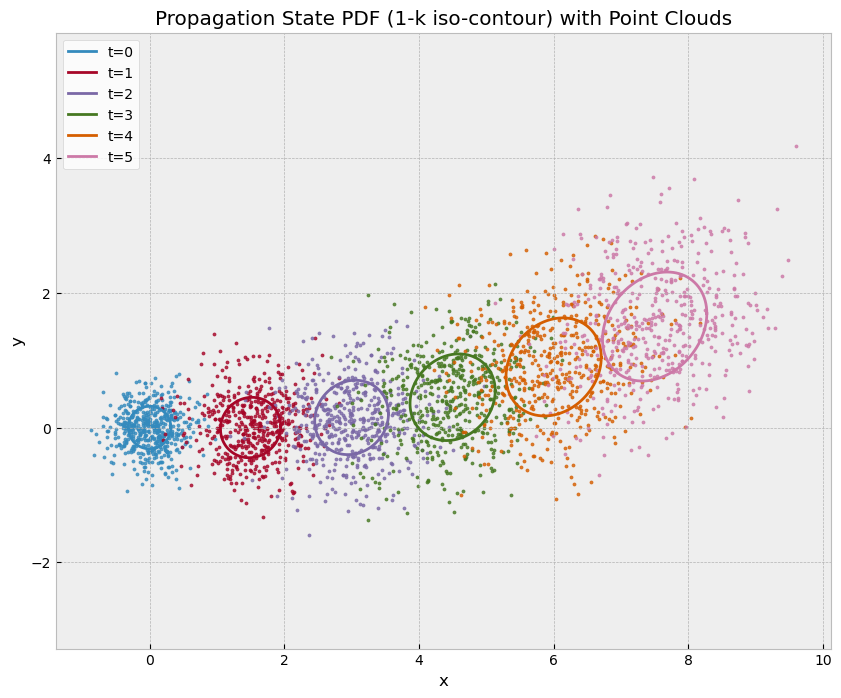

In [14]:
mu_initial = np.array([0, 0])
u_control = np.array([3, 0])
cov_initial = np.array([[0.1, 0], [0, 0.1]])
sigma_eta = np.array([[0.1, 0], [0, 0.1]])
dt = 0.5

A = np.array([[1, 0], [0.1, 1]])
B = np.array([[dt, 0], [0, dt]])

plt.figure(figsize=(10, 8))

for n in range(6):
    if n == 0:
        mu_t = mu_initial
        sigma_t = cov_initial
    else:
        # Calculate mean at time t using new state transition model
        mu_t = A@mu_prev + B@u_control
        
        # Calculate covariance at time t
        sigma_t = ((A@sigma_prev)@A.T) + sigma_eta
    
    mu_prev = mu_t
    sigma_prev = sigma_t
    
    L = np.linalg.cholesky(sigma_t)
    
    theta = np.linspace(0, 2*np.pi, 100)
    ellipse = np.zeros((2, theta.size))
    
    for i in range(theta.size):
        circle_pt = np.array([np.cos(theta[i]), np.sin(theta[i])])
        ellipse_pt = mu_t + L@circle_pt
        ellipse[:,i] = ellipse_pt

    plt.plot(ellipse[0,:], ellipse[1,:], label=f't={n}')
    
    num_points = 500
    samples = np.random.randn(2, num_points)
    points = mu_t.reshape(-1,1) + L@samples
    
    plt.scatter(points[0,:], points[1,:], alpha=0.8, s=5)

plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Propagation State PDF (1-k iso-contour) with Point Clouds')
plt.legend(facecolor='white')
plt.axis('equal')


Note: In some portions of this document (not exceeding 15% of the entire text) Artificial Intelligence assistant, particularly Generative AI, has been used to rephrase, shorten, or summarize the content. The technologies used include Claude 3.5-Sonnet and Perplexity.